** Import Libraries **

In [2]:
## Import libraries

import os, glob, pandas as pd
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
import string, re
import numpy as np
from tqdm import tqdm
from collections import Counter
import numbers
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


** Input Raw Data & HISCO list **

In [3]:
# Import Raw Data (.csv file with harvested advertisements (using the KB-harvesting script))

os.chdir("C://Users//Ruben//Downloads//metadata//algh_set_90")
df = pd.read_csv('1890-1899.csv', sep = '\t')

# to extract a random sample of advertisements:
#df = df.sample(n=20000)
#df = df.reset_index(drop=True)


# Import HISCO list
os.chdir("C://Users//Ruben//Documents//GitHub//dhl-ads//resources")
with open('list_occ_total.txt', encoding = 'utf-8') as f:
    list_words = f.read().splitlines()

list_words = list(set(list_words))
list_words = list_words + ['loopjongen']

** Define Cleaning and Other Useful Functions **

In [4]:
## Set cleaning (or tokenizing) function
## This function removes punctuation using string + regex and splits sentences on spaces

def clean_and_split_str(txt):
    #strip_special_chars = re.compile("[^A-Za-z0-9#]+")
    translator = str.maketrans('', '', string.punctuation)
    txt = txt.translate(translator)
    txt = re.sub('\s+', ' ', txt).strip()
    txt = txt.lower()
    txt = txt.split(' ')
    return txt

## Function to detect whether a string contains a number

def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

** Data Tokenizing **

In [5]:
df['clean'] = [clean_and_split_str(i) for i in df.ocr]

** Line Extraction **

The loop below searches for occupations in the cleaned articles. A list is used that includes the HISCO occupation and OCR-'alternatives' aquired through word embeddings and string distance measuring. Once an occupation is identified, a region 'around' it (L12:R40) is selected. This window is chosen because it seems to yield the most occupation-wage combinations. Larger windows to the right can be considered.

Two choices in this step influence the outcome

- the window. Lots of close reading more or less shows that the occupation - wage combi is found relatively close together, allowing for a relatively small window (< 50 to the right).

- the word 'loon'. If this word is not in the extracted window or 'slice', the window is not included. Again, reading through lots of advertisements justifies this choice, because practically all the job advertisements contains the word 'loon'. 

In [78]:
lo = list() 
ctr = 0 # counter for showing progress

for c,i in enumerate(df.clean):
    ctr += 1
    
    if any(e in i for e in list_words):     # check if there is an occupation in the advertisement
        
        occ = list()
        
        for w in i:                         # loop over every word and check if it is an advertisement (faster using list comprehension!!!!)
            if w in list_words:
                occ.append(w)
        
        for o in occ:                       # loop over occupations in ad-occupation list and select windows around 'em
            ind = i.index(o)
            sl = i[ind-12:ind+40]
            sl = ' '.join(sl)
            if 'loon ' in sl:               # if the word 'loon' is in the window; append [occupation:window] to list (not dictionary because of duplicate occupations)
                lo.append([o,sl])
        
    if ctr % 10000 == 0:                    # print the progress
        print(str(round(ctr / len(df.clean) * 100)) + "%")

11%
22%
32%
43%
54%
65%
75%
86%
97%


** Set Wage Extraction Function **

In the function below, we specify how wages should be extracted. The function requires a string input (the windows extracted in the previous step). The steps are the following:

- we split the string in a list of words (on spaces, because we tokenized earlier)
- we identify the location of the word "loon"
- we select a window around "loon" #windowinception
- we extract the words in this loon-window that contain numbers (using the function defined earlier)
- then, there are two options:
    - the list of tokens-containing-numbers is empty: we either  look if indicative words such as 'goed' and 'hoog' are in the window-in-window and set the value of wage to "qualitative", or, when this is not the case we leave this advertisement to rott in the gutters of Delpher.
    - the list of tokens-containing-numbers contains numbers: we identify the position of this number-containing-token and if it is one or two positions right of loon, it is set as the wage corresponding to the occupation. If it is farther away it is probably a random number or an OCR error

In [60]:
def CloseRangeWage(string):
    # Split string
    s = string.split()
    
    # Check if we have separate f-sign, no f-sign or one f-sign combined with wages
    
    loon_instance = [x for x in s if "loon" in x]
    loon_instance_index = s.index(loon_instance[0])
    loon_proximity_string = s[loon_instance_index-3:loon_instance_index + 4]
    
    tokens_w_digits = list([token for token in loon_proximity_string if hasNumbers(token) == True])
    
    ## If there are no tokens with digits:
    
    if len(tokens_w_digits) == 0:
        
        list_qualitative_wage_indicators=['goed', 'hoog', 'behoorlijk', 'bekwaamheid', 'overeen', 'flink']

        if any(x in loon_proximity_string for x in list_qualitative_wage_indicators):

            qualitative_wage = list([i for i in loon_proximity_string if i in list_qualitative_wage_indicators])
            if len(qualitative_wage) > 0:
                loon = "qualitative"
                                     
        elif "ƒ" in s[loon_instance_index+1] or "f" in s[loon_instance_index+1]:
            
            if len(s[loon_instance_index+1]) == 1:
                if len(s) <= loon_instance_index+2:
                    loon = "no wage indication"
                else: 
                    loon = s[loon_instance_index+2]
            if len(s[loon_instance_index+1]) >= 1:
                if len(s) < loon_instance_index+1:
                    loon = "no wage indication"
                else: 
                    loon = s[loon_instance_index+1]
                    
        elif any(x in loon_proximity_string for x in ['gulden']):
        
            gulden_wage = list([i for i in loon_proximity_string if i in ['gulden']])[0]
            
            index_gulden = s.index(gulden_wage)
            
            loon = s[index_gulden-1]
            
        else:    
            loon = "no wage indication"
        
    ## If there are tokens with digits:
    
    for token in tokens_w_digits:
        
        # Check if token before token with digit is "loon"
        
        token_index = loon_proximity_string.index(token)
        
        if loon_proximity_string[token_index-1] == "loon" or loon_proximity_string[token_index-2] == "loon":
            loon = token
            
        else:
            loon = "no wage indication"
            
    return loon

** Define a Function that Converts the Number-Containing-Token to a quantifyable wage **

The advertisement OCR is pretty bad. Many of the wages identified earlier are misinterpreted. Also, the currency sign ('f') is sometimes not separated from the wage itself. The function below converts the wage-string to a number and solves the most common OCR-errors (1 as l, 0 as o, f in wage).

In [ ]:
def WageString2Number(string):

    ## Check for f in beginning:
    
    if string[0] == "f" or string[0] == "ƒ":
    
        string = string.replace("ƒ","")
        string = string.replace("f","")
        
    string = string.replace("l", "1")
    string = string.replace("o", "0")
    
    try:
        wage = int(string)
        
    
    except ValueError:
        wage = "inconvertable"
        
    return wage

** Run the Functions **

In [79]:
results = list()

for k,v in lo:
    
    res = CloseRangeWage(v)
    
    results.append([k,res])
result_df = pd.DataFrame([[v for k,v in results], [k for k,v in results]]).T
result_df.columns = ['res', 'occ']

** Set Function to make a histogram of wages (for specific occupations) **

In [52]:
def PlotOccupation(occ, wage_limit, fuzzy_or_not):
    
    if fuzzy_or_not == "no":
        dfk = result_df[result_df['occ'] == occ]
        len_list_occ = len(dfk)
    if fuzzy_or_not == "yes":
        dfk = result_df[result_df['occ'].str.contains(occ)]
        len_list_occ = len(dfk)
    dfk = dfk[dfk['res'] != "no wage indication"]
    dfk = dfk[dfk['res'] != "qualitative"]
    
    wage_res = list()

    for i in list(dfk.res):
        r = WageString2Number(i)
        wage_res.append(r)
    
    wage_res_w = [x for x in wage_res if isinstance(x, numbers.Number)]
    wage_res = [x for x in wage_res_w if x < wage_limit]
    plt.hist(wage_res, edgecolor='black', linewidth=1.2)
    plt.ylabel('Observations')
    plt.xlabel("Observed Wages lower than " + str(wage_limit))
    
    if fuzzy_or_not == "yes":
        plt.title("Histogram of occupations containing " + occ)
        
    if fuzzy_or_not == "no":    
        plt.title("Histogram of " + occ + " wages. N = " + str(len(wage_res_w)) + " | " + str(round(len(wage_res_w) / len_list_occ * 100)) + "%")

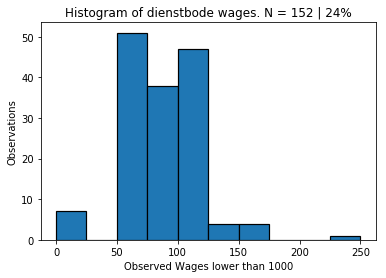

In [84]:
PlotOccupation("dienstbode", 1000, "no")

** Set Function to make a histogram of wages (for multiple occupations) **

In [66]:
def PlotMultipleOccupations(list_of_occ, wage_limit):
    
    plt.figure(figsize=(20,10))

    for occ in list_of_occ:
        dfk = result_df[result_df['occ'] == occ]
        len_list_occ = len(dfk)
        dfk = dfk[dfk['res'] != "no wage indication"]
        dfk = dfk[dfk['res'] != "qualitative"]

        wage_res = list()

        for i in list(dfk.res):
            r = WageString2Number(i)
            wage_res.append(r)

        wage_res_w = [x for x in wage_res if isinstance(x, numbers.Number)]
        wage_res = [x for x in wage_res_w if x < wage_limit]
        plt.hist(wage_res, edgecolor='black', linewidth=1.2, alpha = 0.7, label = occ + " | N = " + str(len(wage_res_w)) + " | " + str(round(len(wage_res_w) / len_list_occ * 100)) + "%")
    
    
    
    plt.ylabel('Observations')
    plt.xlabel("Observed Wages lower than " + str(wage_limit))
    plt.title("Histogram of wages of: " + ", ".join(list_of_occ))
    plt.legend(loc='upper right')
    plt.show()

ZeroDivisionError: division by zero

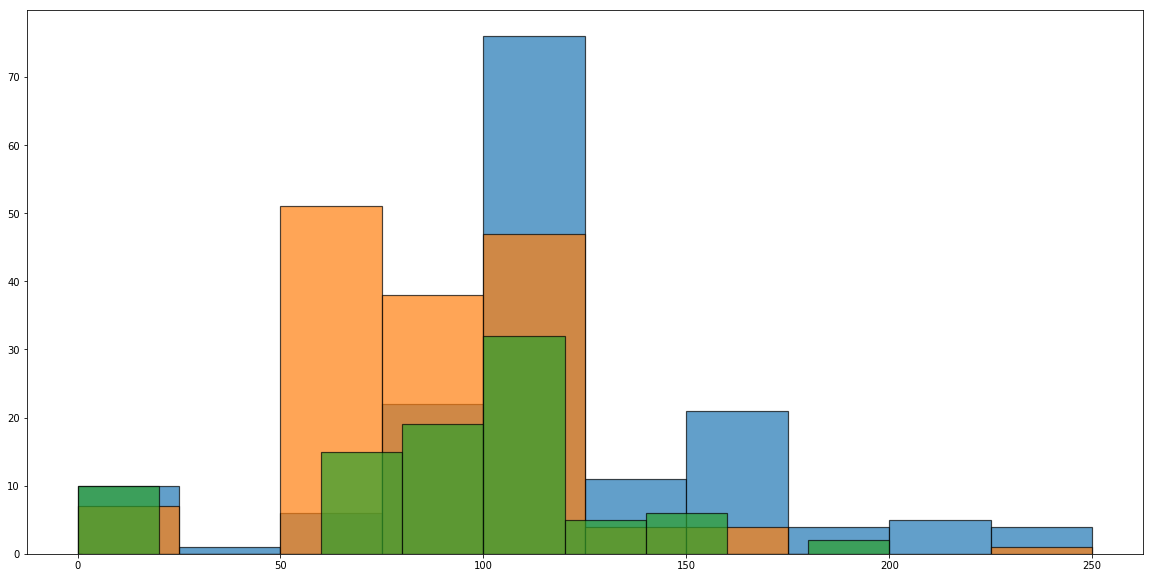

In [85]:
PlotMultipleOccupations(['keukenmeid', 'dienstbode', 'meid', 'loopjongen', ''], 1000)

** Set Function for Extracting Temporal Markers **

Wages can be specified in differnt ways. Most common are wages specified for years, but months and weeks also occur. This function attempts to extract thos temporal units, using the extracted windows. The function searches for the words and checks if the character "p" is in the word before this word, because "per week" is a common way of specifying the wage earned per week. Matching the full word "per" proves to be too strict.

In [273]:
def GetTime(string):
    
    s = string.split()
    
    if any(x in s for x in ['dag', 'maand', 'jaar']):
        time_instance = list([i for i in s if i in ['dag', 'maand', 'jaar']])[0]
    
        time_instance_index = s.index(time_instance)
    
        if "p" in s[time_instance_index - 1] and time_instance_index - 1 >= 0:

            time = time_instance
            
        else:
            time = "no_time"
            
    else:
        time = "no_time"
        
    return time

In [292]:
timel = list()
for k,v in lo:
    r = GetTime(v)
    timel.append(r)
Counter(timel)

In [290]:
result_df.to_csv('algh-extracted-wages.csv', index=False)

In [74]:
[v for k,v in lo if k == "loopjongen"]

['tegen hoog loon zoo spoedig mogelijk bij p woert te mijdrecht 18652 loopjongen om direct in dienst te treden wordt verlangd een flinke loopjongen p g om huiswerk te verrichten en bood schappen te doen en verder tot huisknecht te worden opgeleid goede getuigen zijn hoofd vereischten brieven franco onder no 18653',
 'tegen hoog loon zoo spoedig mogelijk bij p woert te mijdrecht 18652 loopjongen om direct in dienst te treden wordt verlangd een flinke loopjongen p g om huiswerk te verrichten en bood schappen te doen en verder tot huisknecht te worden opgeleid goede getuigen zijn hoofd vereischten brieven franco onder no 18653',
 'in prjs verminderde boeken op aanvrage gratis en franco verkrijgbaar 19985 ten loopjongen gevraagd van ongeveer 15 jaar voor dadelijk loon ƒ 250 per week adres zuidblaak 16 20337 ecu bekwaam huisknecht wordt gevraagd met november of vroeger van den p g niet beneden de 30 jaar en goede getuigschriften kunnende overleggen',
 'doos artikelen onmisbaar in elke huish